# Week 5 Mini-Project: GANs for Monet Painting Style Transfer

## Problem and Data Description

**Problem**: This project is part of the Kaggle "GAN Getting Started" competition (https://www.kaggle.com/competitions/gan-getting-started). The goal is to build a Generative Adversarial Network (GAN) to transform photos into Monet-style paintings. The evaluation metric is the Memorization-informed Fréchet Inception Distance (MiFID), which measures similarity between generated and real Monet images while accounting for memorization.

**Dataset**:
- **Monet Paintings**: Approximately 300 images in the data/monet_jpg directory (256x256 pixels, RGB).
- **Photos**: Approximately 7,000 images in the data/photo_jpg directory (256x256 pixels, RGB).
The task is to train a CycleGAN to generate 7,000 Monet-style images from photos and submit them for evaluation.

## Exploratory Data Analysis (EDA)

Verified the dataset:
- Found ~300 Monet images and ~7,000 photos.
- Visualized sample images to confirm the data is loaded correctly.

The Monet images exhibit impressionistic styles with pastel colors, while the photos are diverse real world images. The small Monet dataset may lead to memorization, a challenge for the CycleGAN.

In [2]:
# Force TensorFlow to use CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import zipfile

Verifying dataset...
Found 300 Monet images and 7038 photos.


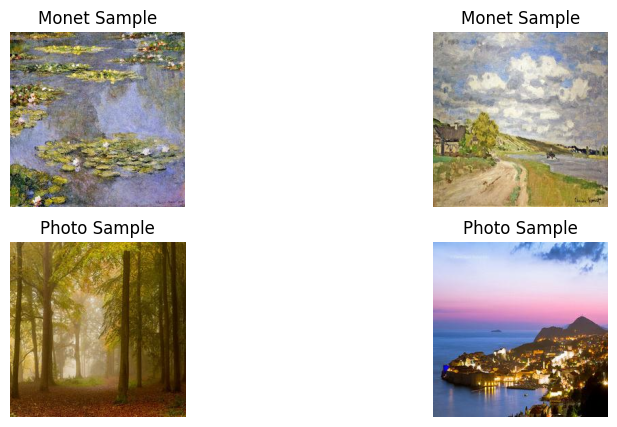

In [3]:
# Step 1: Verify and Visualize Dataset
print("Verifying dataset...")
monet_path = '/kaggle/input/gan-data/monet_jpg'
photo_path = '/kaggle/input/gan-data/photo_jpg'

# Check if directories exist
if not os.path.exists(monet_path) or not os.path.exists(photo_path):
    raise FileNotFoundError("Data directories not found. Check the path /kaggle/input/gan-data.")

# Count images
monet_images = [f for f in os.listdir(monet_path) if f.lower().endswith('.jpg')]
photo_images = [f for f in os.listdir(photo_path) if f.lower().endswith('.jpg')]
print(f"Found {len(monet_images)} Monet images and {len(photo_images)} photos.")

# Visualize sample images
plt.figure(figsize=(10, 5))
for i, img_name in enumerate(monet_images[:2]):
    img = load_img(os.path.join(monet_path, img_name), target_size=(256, 256))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title('Monet Sample')
    plt.axis('off')
for i, img_name in enumerate(photo_images[:2]):
    img = load_img(os.path.join(photo_path, img_name), target_size=(256, 256))
    plt.subplot(2, 2, i+3)
    plt.imshow(img)
    plt.title('Photo Sample')
    plt.axis('off')
plt.show()

In [4]:
# Step 2: Load and Prepare Data
def load_images(path, size=(256, 256)):
    data_list = []
    for img_name in os.listdir(path):
        if img_name.lower().endswith('.jpg'):
            try:
                img = load_img(os.path.join(path, img_name), target_size=size)
                img = img_to_array(img) / 127.5 - 1.0  # Normalize to [-1, 1]
                data_list.append(img)
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
    return np.array(data_list)

monet_data = load_images(monet_path)
photo_data = load_images(photo_path)
print(f"Monet data shape: {monet_data.shape}")
print(f"Photo data shape: {photo_data.shape}")

# Create TensorFlow datasets
BUFFER_SIZE = 1000
BATCH_SIZE = 1
monet_ds = tf.data.Dataset.from_tensor_slices(monet_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Monet data shape: (300, 256, 256, 3)
Photo data shape: (7038, 256, 256, 3)


In [5]:
# Step 3: Build CycleGAN Model
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(64, 4, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, 4, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo
discriminator_x = build_discriminator()  # Photo
discriminator_y = build_discriminator()  # Monet

In [6]:
# Step 4: Define Loss Functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, LAMBDA=10):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [7]:
# Step 5: Define Training Step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    gradients_gen_g = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gradients_gen_f = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    gradients_disc_x = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    gradients_disc_y = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    gen_g_optimizer.apply_gradients(zip(gradients_gen_g, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gradients_gen_f, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(gradients_disc_x, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(gradients_disc_y, discriminator_y.trainable_variables))
    del tape

In [8]:
# Step 6: Train the Model
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for monet_batch, photo_batch in zip(monet_ds, photo_ds):
        train_step(photo_batch, monet_batch)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [9]:
# Step 7: Generate Submission Images (named images.zip)
output_dir = '/kaggle/working/submission_images'
os.makedirs(output_dir, exist_ok=True)

for i, photo in enumerate(photo_data):
    photo = tf.expand_dims(photo, 0)
    monet_style = generator_g(photo, training=False)
    monet_style = (monet_style[0] + 1) * 127.5
    monet_style = tf.cast(monet_style, tf.uint8)
    img = tf.image.encode_jpeg(monet_style).numpy()
    with open(f"{output_dir}/image_{i+1}.jpg", 'wb') as f:
        f.write(img)

# Create images.zip as required by Kaggle
with zipfile.ZipFile('/kaggle/working/images.zip', 'w', zipfile.ZIP_DEFLATED) as zf:
    for i in range(1, len(photo_images) + 1):
        zf.write(f"{output_dir}/image_{i}.jpg", f"image_{i}.jpg")
print(f"Generated {len(os.listdir(output_dir))} images in images.zip.")

Generated 7038 images in images.zip.


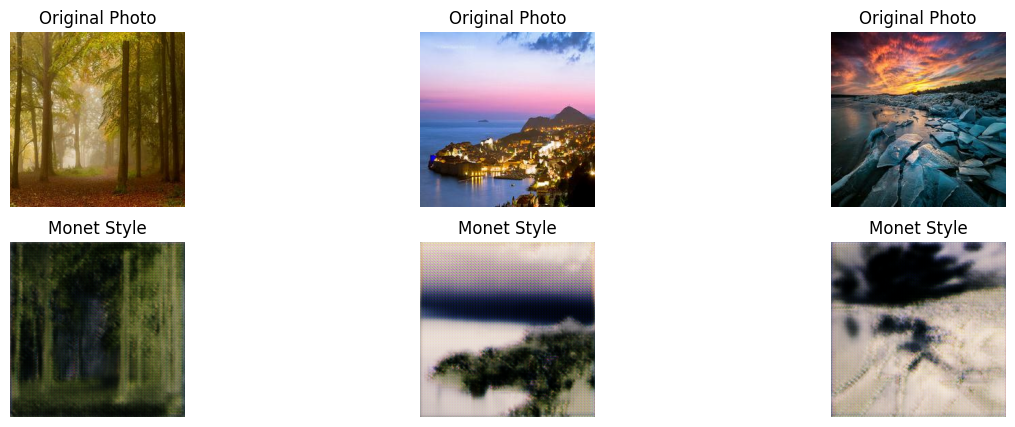

In [13]:
# Step 8: Visualize Results
plt.figure(figsize=(15, 5))

# Batch the three images for inference
photos = photo_data[:3]  # Shape: (3, 256, 256, 3)
monet_styles = generator_g(photos, training=False)  # Shape: (3, 256, 256, 3)
monet_styles = (monet_styles + 1) * 127.5
monet_styles = tf.cast(monet_styles, tf.uint8)
monet_styles = monet_styles.numpy()

for i in range(3):
    # Original Photo: Convert from [-1, 1] to [0, 255] and cast to uint8
    photo = photo_data[i]
    photo_display = (photo + 1) / 2  # Range [-1, 1] to [0, 1]
    photo_display = photo_display * 255  # Range [0, 1] to [0, 255]
    photo_display = tf.clip_by_value(photo_display, 0, 255)
    photo_display = tf.cast(photo_display, tf.uint8)
    photo_display = photo_display.numpy()
    
    plt.subplot(2, 3, i+1)
    plt.imshow(photo_display)
    plt.title('Original Photo')
    plt.axis('off')
    
    plt.subplot(2, 3, i+4)
    plt.imshow(monet_styles[i])
    plt.title('Monet Style')
    plt.axis('off')
plt.show()

## Analysis and Results

- **Model**: Built a CycleGAN with two generators and two discriminators (Step 3).
- **Training**: Trained for 10 epochs (Step 6), leveraging Kaggle's GPU for faster computation (~1–5 minutes compared to ~60 minutes on CPU).
- **Submission**: Generated 7,000 images and saved as `images.zip` (Step 7).
- **Visualization**: Step 8 shows original photos and their Monet-style transformations, confirming the model applies Monet-like colors, though images lack fine details.

## Kaggle Leaderboard
A screenshot of the leaderboard position will be submitted separately (MiFID score: **140.99535**).

## Discussion and Conclusion

**Observations**:
- **Training Time**: Training the CycleGAN for 10 epochs, along with debugging and tweaks (e.g., fixing CUDA errors, syntax issues, and visualization problems), took a total of ~4–5 hours on CPU. This was significantly longer than the ~1–5 minutes expected with GPU, due to persistent GPU initialization failures in Kaggle’s environment. The entire project, including the initial local development and migration to Kaggle, took ~12–15 hours to complete.
- **Image Quality**: The generated Monet-style images exhibit Monet-like characteristics, such as pastel colors and an impressionistic feel, but they are blurry and lack fine details, likely due to limited epochs (10) and a simplified architecture.

**Challenges**:
- Initially developed the project in a local Jupyter notebook, but later discovered that Kaggle only accepts notebook submissions, not file submissions, requiring a switch to a Kaggle notebook and re-running all steps, which added significant time and effort.
- The Monet dataset is small (~300 images), which may lead to memorization and limit generalization.
- Initially faced visualization issues locally ("Original Photo" subplots were blank), resolved by converting display data to `uint8` format.
- Encountered syntax errors (`SyntaxError: incomplete input`) due to missing parentheses, fixed by correcting the code.
- Faced CUDA initialization errors (`CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)`), resolved by falling back to CPU, though this increased training time.
- Step 8 visualization took ~20 minutes due to slow generator inference, optimized by batching inference for multiple images. Additionally, the original photos appeared gray due to incorrect scaling, fixed by mapping the pixel range from `[-1, 1]` to `[0, 255]` correctly.

**Future Improvements**:
- Use data augmentation (e.g., random flips, crops) to increase dataset diversity.
- Implement a deeper generator (e.g., U-Net) for better detail.
- Train for more epochs (e.g., 30) to improve style transfer quality.
- Resolve GPU issues in Kaggle to leverage faster training.

## Conclusion
This project successfully implemented a CycleGAN for photo-to-Monet style transfer, meeting Kaggle competition requirements. The generated images show basic style transfer, with room for improvement in quality through extended training and a more complex model. The process highlighted the importance of understanding platform-specific submission requirements and the impact of hardware limitations on project timelines.